# Importing of libraries

In [109]:
#import necessary libraries
import numpy as np
import pandas as pd

#import visualisation libraries
import plotly.express as px
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

#import Statistics libraries
from scipy import stats
from scipy.stats import norm

#import model libraries
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske

In [110]:
raw_data = pd.read_csv('jobs_in_data_2024.csv')

# Data Analysis

In [111]:
#checking for unique values
for column in raw_data.columns:
    num_distinct_values = len(raw_data[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

work_year: 5 distinct values
experience_level: 4 distinct values
employment_type: 4 distinct values
job_title: 149 distinct values
salary: 2229 distinct values
salary_currency: 12 distinct values
salary_in_usd: 2578 distinct values
employee_residence: 86 distinct values
work_setting: 3 distinct values
company_location: 74 distinct values
company_size: 3 distinct values
job_category: 10 distinct values
work_year_normalized: 5 distinct values
adjust_salary_normalized: 3506 distinct values
exeperience_level_favor: 4 distinct values
employment_type_favor: 4 distinct values


In [112]:
raw_data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,work_setting,company_location,company_size,job_category,work_year_normalized,adjust_salary_normalized,exeperience_level_favor,employment_type_favor
0,2024,Entry-level,Freelance,Applied Data Scientist,30000,USD,30000,United Kingdom,Remote,United Kingdom,M,Data Science and Research,1.0,0.025870,NaN,0
1,2024,Executive,Full-time,Business Intelligence,230000,USD,230000,United States,In-person,United States,M,BI and Visualization,1.0,0.409646,0.0,3
2,2024,Executive,Full-time,Business Intelligence,176900,USD,176900,United States,In-person,United States,M,BI and Visualization,1.0,0.307753,0.0,3
3,2024,Senior,Full-time,Data Architect,171210,USD,171210,Canada,In-person,Canada,M,Data Architecture and Modeling,1.0,0.296835,1.0,3
4,2024,Senior,Full-time,Data Architect,92190,USD,92190,Canada,In-person,Canada,M,Data Architecture and Modeling,1.0,0.145205,1.0,3


**Now because salary is affected by inflation rate for different years, lets bring all the salaries up to date 
with what it would be currently**

**sources:**
- [US inflation rates](https://www.investopedia.com/inflation-rate-by-year-7253832)
- [Global inflation rates](https://www.macrotrends.net/global-metrics/countries/WLD/world/inflation-ratecpi#:~:text=World%20inflation%20rate%20for%202022,a%200.23%25%20decline%20from%202018)


# Adjust Salary Function

In [113]:
# inflation rates
us_inflation_rates = {2020: 0.0140, 2021: 0.070, 2022: 0.065, 2023: 0.034}
global_inflation_rates = {2020: 0.0193 , 2021: 0.0348, 2022: 0.087, 2023: 0.068}


# function to adjust salary
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']
    if year == 2024:
        return original_salary
        
    adjusted_salary = original_salary
    for y in range(year, 2024):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]
        adjusted_salary *= (1 + inflation_rate)
    return adjusted_salary

# apply function to dataset
raw_data['adjust_salary'] = raw_data.apply(adjust_salary, axis=1)

In [114]:
raw_data['adjust_salary']

0         30000.000000
1        230000.000000
2        176900.000000
3        171210.000000
4         92190.000000
             ...      
14194    194418.625500
14195    492253.820230
14196    177922.499700
14197    125453.036709
14198    119479.082580
Name: adjust_salary, Length: 14199, dtype: float64

# Uni-Variate Analysis

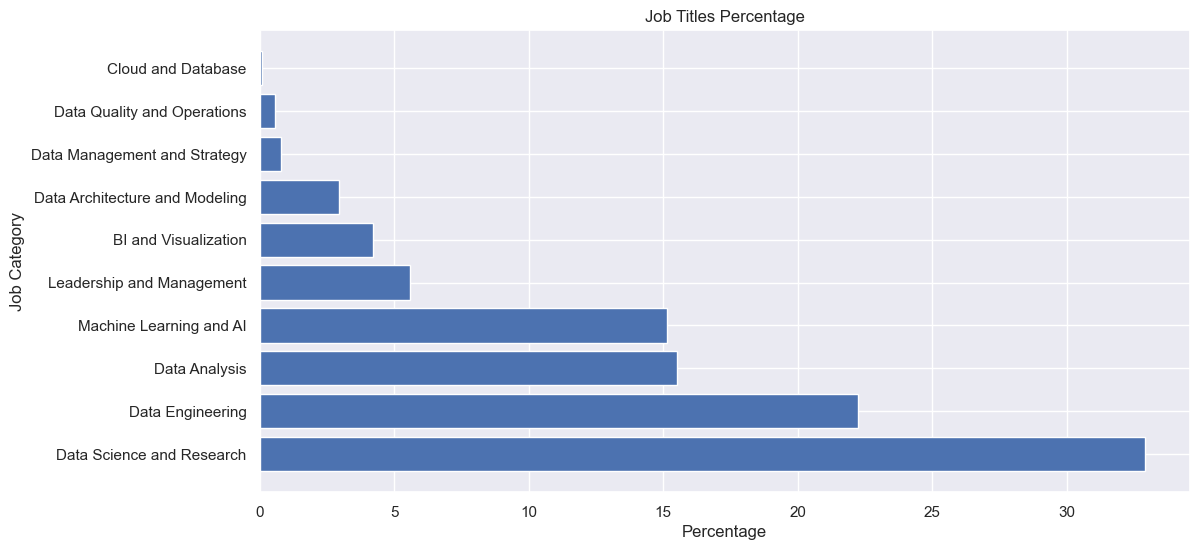

In [115]:
value_counts = raw_data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12,6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

## Salary distribution across different employment types

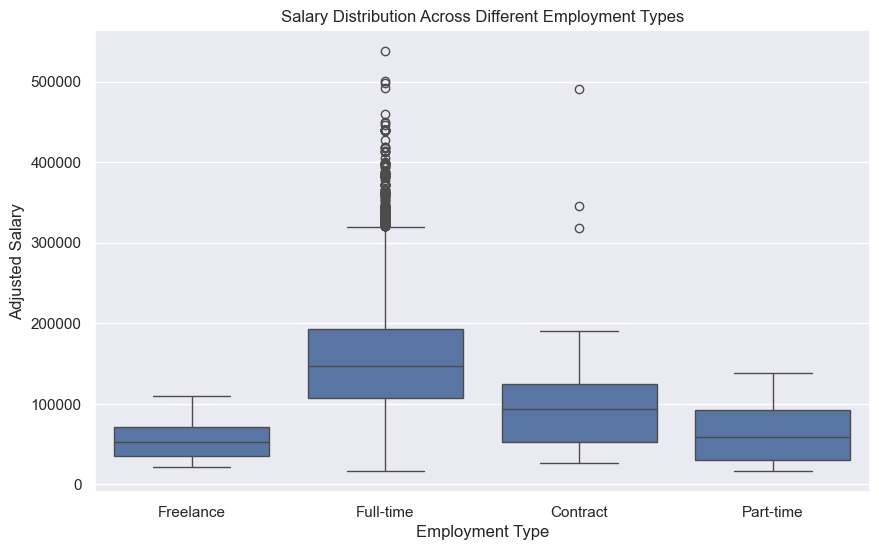

In [116]:

plt.figure(figsize=(10, 6))
sb.boxplot(data=raw_data, x='employment_type', y='adjust_salary')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Adjusted Salary')
plt.show()

**Purely from analysis, this means that Full-time jobs pay the best, we should then consider only Full-time jobs in our later analysis**

## Distribution of Adjusted Salary

adjust_salary: mu = 154710.67, sigma = 66196.13
adjust_salary: Skewness: 0.74
adjust_salary: Kurtosis: 0.93


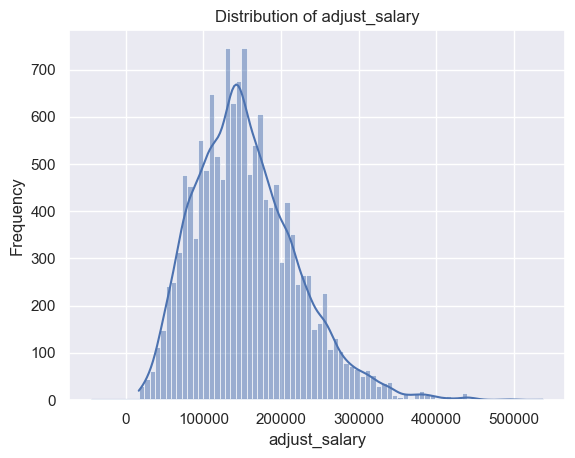

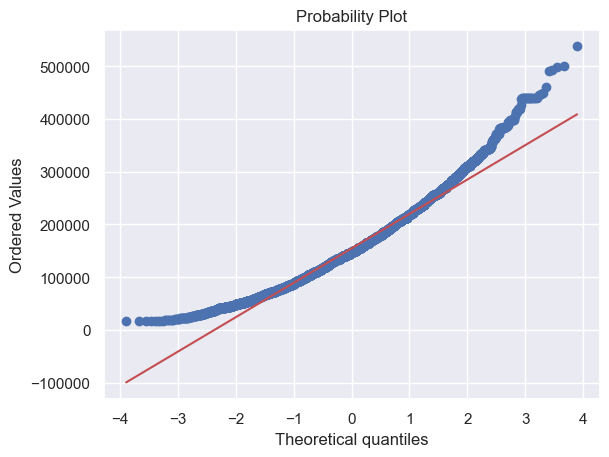

In [117]:
# Create list of the columns to analyze
columns = ['adjust_salary']

# Loop over columns and plot distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sb.histplot(raw_data[col], kde=True)
    
    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(raw_data[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))
    
    # Calculate skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, raw_data[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, raw_data[col].kurt()))
    
    # Add fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')
    
    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(raw_data[col], plot=plt)

    plt.show()
    

# Creating a scale using normalization for selected variables
- this is done with the intention to quantify how favorable a selected variable is in determining the best job
- How to calculate normalization:
  1. Calculate range of data set. i.e. Range of x = x max - x min
  2. Subtract minimum x value from value at current data point. i.e. x current - x min
  3. Insert value into formula and divide
     - Equation is as follows: x normalized = (x - x min) / range of x

## Selected columns that might affect how good a job
- work_year
- experience_level (not numerical, need to quantify into a number)
- employment_type (not numerical, need to quantify into a number)
- adjust_salary

In [118]:
# these are the parameters set for the function usage below
input_csv = 'jobs_in_data_2024.csv'
output_csv = 'modified_dataset.csv'
selected_columns = ['work_year', 'adjust_salary']

## Normalizer & add_to_csv functions

In [119]:
# function to calculate normalized values for selected column
# using the adjusted salary as an example...

def normalizer(col):
    '''
    Parameters:
        col: the column of data to be normalized

    Returns:
        list: the normalized column of data
    '''
    min_val = min(col)
    max_val = max(col)
    normalized_data = [(x - min_val)/(max_val - min_val) for x in col]
    return normalized_data

# function to write the normalization to a new csv with side by side comparison
def add_normalize_to_csv(input_csv, output_csv, column_name):
    """
    Parameters:
        input_csv (str): Path to input CSV file
        output_csv (str): Path to output CSV file
        column_name (str): name of the column to be normalized
    """
    # Read CSV file
    df = pd.read_csv(input_csv)
    # normalize desired column
    normalized_column = normalizer(raw_data[column_name])

    # add normalized column to dataframe
    df[column_name + '_normalized'] = normalized_column

    # Write the dataframe back to CSV
    df.to_csv(output_csv, index=False)

## Normalizing of data

In [120]:
for name in selected_columns:
    add_normalize_to_csv(input_csv, output_csv, name)

## Creation of dummy variables for categorical factors
- experience_level
- employment_type

In [121]:
# function to add a new column to csv
def add_to_csv(df, column_name):
    df[column_name].to_csv('modified_dataset.csv', index=False, mode='a+')

# function to create boolean columns for categorical variables
def create_bool_col(df, column_name):
    df_encoded = pd.get_dummies(df, columns=[column_name]).astype(int)

    for column in df_encoded.columns:
        add_to_csv(df_encoded, column)

### Experience_level

In [122]:
# for experience level
unique_values = raw_data['experience_level'].unique()
print(unique_values)

['Entry-level' 'Executive' 'Senior' 'Mid-level']


**Now that we have the possible variables, we need to convert them to numerical values**

In [123]:
# Read csv
dataframe = pd.read_csv(input_csv)

# Creating new columns such as Full-Time, Entry-Level which will either be 0 or 1
df_encoded = pd.get_dummies(dataframe, columns=['experience_level'])

for column in df_encoded.columns:
    add_to_csv(df_encoded, column)

### Employment_type

In [124]:
# for employment type
unique_values = raw_data['employment_type'].unique()
print(unique_values)

['Freelance' 'Full-time' 'Contract' 'Part-time']


In [125]:
# read csv


**Now let's check the new column**

In [126]:
df = pd.read_csv(input_csv)
df['employment_type_favor'].unique()

array([0, 3, 1, 2], dtype=int64)

# Random Forest Regression

In [127]:
# importing libraries
import sklearn as sk
import sklearn.ensemble as ske
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [128]:
# read dataset
df = pd.read_csv('data_set.csv')


# from previous analysis of correlation, we have found that the following columns are related to salary
predictors_column_name = [
    'experience_level',
    'employee_residence',
    'company_location',
    'company_size',
    'job_category'
]

# now that we have our predictors, let's create dummy variables for the non-numerical columns
def create_dummy_variables_for_columns(data, columns):
    # Create a copy of the DataFrame to avoid modifying the original data
    data_copy = data.copy()
    
    # Create an empty DataFrame to store the encoded data
    encoded_data = pd.DataFrame()
    
    # Iterate over specified columns
    for column in columns:
        # Create dummy variables for the column
        dummy_df = pd.get_dummies(data_copy[column], prefix=column, drop_first=True)
        
        # Convert True/False values to 1/0
        dummy_df = dummy_df.map(lambda x: 1 if x else 0)
        
        # Append the dummy DataFrame to the encoded data
        encoded_data = pd.concat([encoded_data, dummy_df], axis=1)
    
    return encoded_data

predictor_df = create_dummy_variables_for_columns(df, predictors_column_name)
predictor_df

,experience_level_Executive,experience_level_Mid-level,experience_level_Senior,employee_residence_American Samoa,employee_residence_Andorra,employee_residence_Argentina,employee_residence_Armenia,employee_residence_Australia,employee_residence_Austria,employee_residence_Belgium,...,company_size_S,job_category_Cloud and Database,job_category_Data Analysis,job_category_Data Architecture and Modeling,job_category_Data Engineering,job_category_Data Management and Strategy,job_category_Data Quality and Operations,job_category_Data Science and Research,job_category_Leadership and Management,job_category_Machine Learning and AI
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14194,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14195,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14196,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14197,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


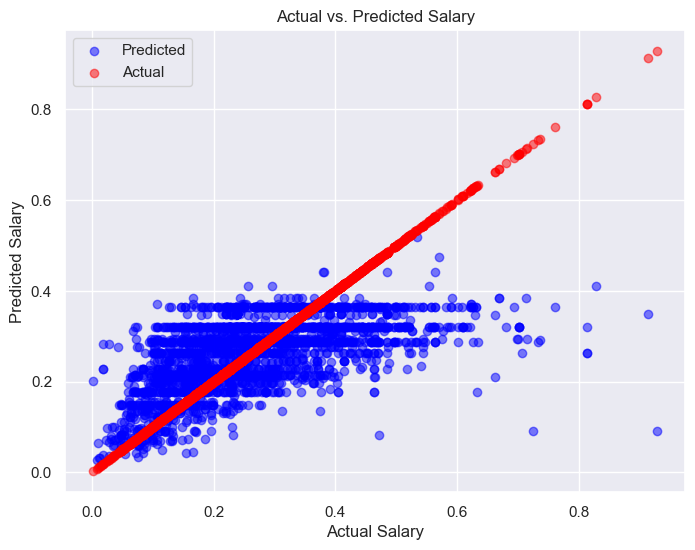

Mean Absolute Error (MAE): 0.08010429795185162
Mean Squared Error (MSE): 0.011235208435803218
Model Score: 30.99%


In [129]:
# Random Forest Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def random_forest_salary_prediction(X, y, estimators):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=estimators, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    # Visualize actual vs predicted salaries
    visualize_predictions(y_test, y_pred)

    # Analytical values
    calculate_metrics(y_test, y_pred)
    
    return rf_model

def calculate_metrics(y_actual, y_predicted):
    mae = mean_absolute_error(y_actual, y_predicted)
    mse = mean_squared_error(y_actual, y_predicted)
    r2 = r2_score(y_actual, y_predicted)*100
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print(f"Model Score: {np.round(r2, 2)}%")
    return None
    
def visualize_predictions(y_actual, y_predicted):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, color='blue', alpha=0.5, label='Predicted')  # Predicted salaries in blue
    plt.scatter(y_actual, y_actual, color='red', alpha=0.5, label='Actual')  # Actual salaries in red
    plt.title('Actual vs. Predicted Salary')
    plt.xlabel('Actual Salary')
    plt.ylabel('Predicted Salary')
    plt.legend()
    plt.show()

trained_model = random_forest_salary_prediction(predictor_df, df['adjust_salary_normalized'], 100)

## Analysis
- R squared value of 0.3 suggests that this model is a poor fit. Perhaps the correlation between salary and the factors themselves are not good enough, hence resulting in poor ability of the model to predict salary based on these factors.
- let's explore another dataset...

# Exploring another Dataset

In [130]:
df = pd.read_csv("Salary Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


In [131]:
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


## Data Processing

In [132]:
# checking for NaN values
df.isna().sum()

Age                    2
Gender                 2
Education Level        2
Job Title              2
Years of Experience    2
Salary                 2
dtype: int64

In [133]:
# removing NaN values
df.dropna(inplace=True)

# Check Again For Nan Values
df.isna().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

In [134]:
# Checking for duplicates
df.duplicated().sum()

49

In [135]:
df[df.duplicated()].head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
195,28.0,Male,Bachelor's,Junior Business Analyst,2.0,40000.0
250,30.0,Female,Bachelor's,Junior Marketing Coordinator,2.0,40000.0
251,38.0,Male,Master's,Senior IT Consultant,9.0,110000.0
252,45.0,Female,PhD,Senior Product Designer,15.0,150000.0
253,28.0,Male,Bachelor's,Junior Business Development Associate,2.0,40000.0


Since duplicates are bound to affect our model, lets remove them

In [136]:
# Drop Duplicates Records
df.drop_duplicates(inplace=True)

# Reset Our Index to be Orderd
df.reset_index(inplace=True, drop=True)

df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


## Data Exploration + Analysis

### Age Column

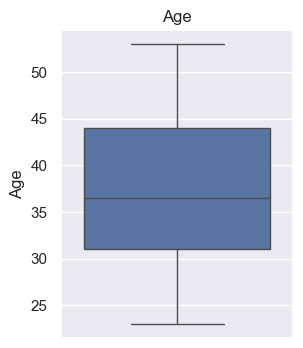

In [137]:
mean_of_age = df["Age"].mean()
median_of_age = df["Age"].median()
plt.figure(figsize=(3, 4))
sb.boxplot(data=df, y='Age')
plt.title('Age')
plt.show()

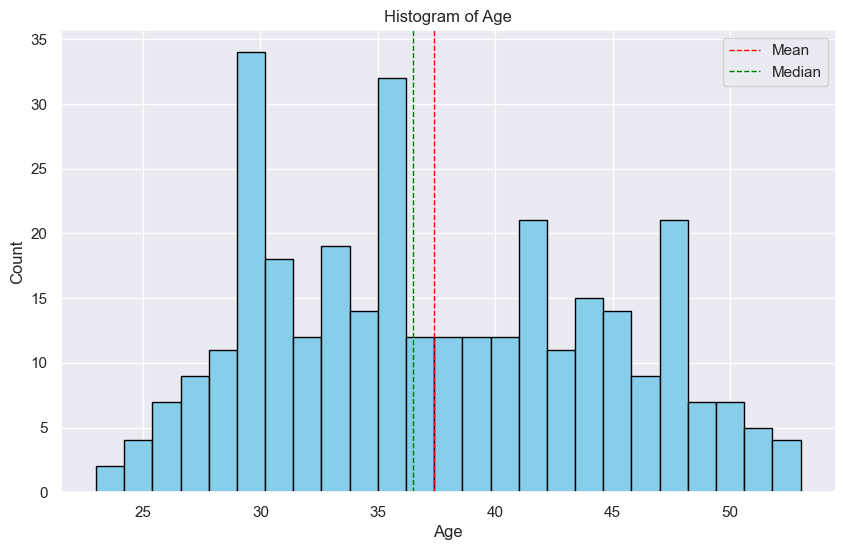

In [138]:
def plot_histogram(data, mean_of_age, median_of_age):
    plt.figure(figsize=(10, 6))
    plt.hist(data['Age'], bins=25, color='skyblue', edgecolor='black')
    plt.title('Histogram of Age')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.grid(True)

    # Add mean and median lines
    plt.axvline(mean_of_age, color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(median_of_age, color='green', linestyle='dashed', linewidth=1, label='Median')
    
    plt.legend()  # Show legend
    plt.show()

plot_histogram(df, mean_of_age, median_of_age)

#### Analysis:
- From this, we can see that there is a somewhat right skewness!

### Gender Column

In [139]:
gender = df["Gender"].value_counts(normalize=1) * 100
gender.apply(lambda x: f"{x:0.2f}%")

Gender
Male      52.47%
Female    47.53%
Name: proportion, dtype: object

C:\Users\Sean Leng\AppData\Local\Temp\ipykernel_13268\1218742864.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



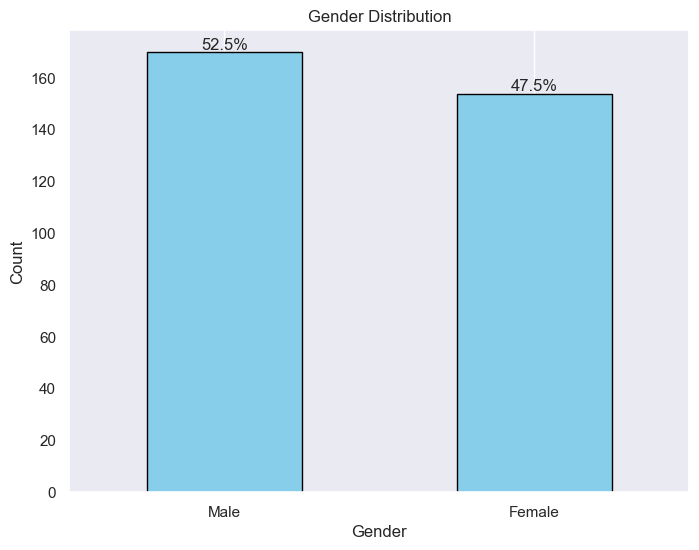

In [140]:
def plot_bar(data, column_name, title):
    # Count the occurrences of each gender
    unique_counts = data[column_name].value_counts()
    
    # Calculate the percentage of each gender
    total_count = unique_counts.sum()
    percentage = (unique_counts / total_count) * 100
    
    # Plot the bar graph
    plt.figure(figsize=(8, 6))
    unique_counts.plot(kind='bar', color=['skyblue'], edgecolor='black')
    
    # Add percentage text on each bar
    for i, count in enumerate(unique_counts):
        plt.text(i, count + 1, f"{percentage[i]:.1f}%", ha='center')
    
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

plot_bar(df, 'Gender', 'Gender Distribution')

### Education Level Column

In [141]:
education = df["Education Level"].value_counts(normalize=1) * 100
education.apply(lambda x: f"{x:0.2f}%")

Education Level
Bachelor's    58.95%
Master's      28.09%
PhD           12.96%
Name: proportion, dtype: object

C:\Users\Sean Leng\AppData\Local\Temp\ipykernel_13268\1218742864.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



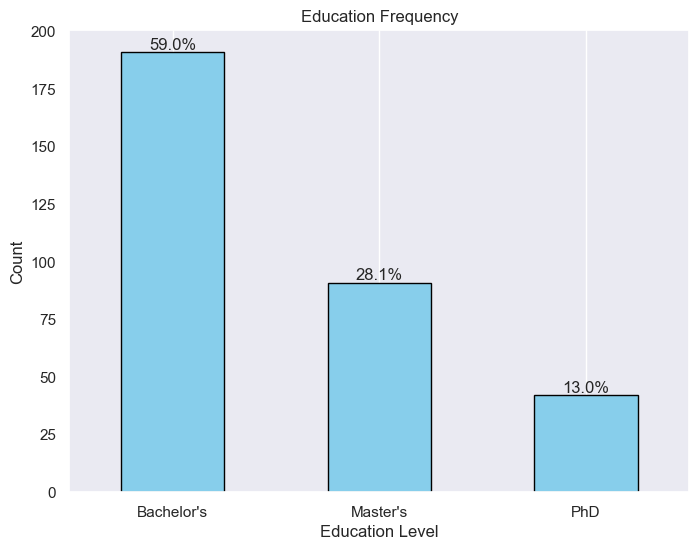

In [142]:
plot_bar(df, "Education Level", "Education Frequency")

### Experience Column

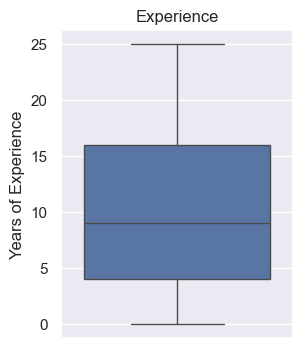

In [143]:
plt.figure(figsize=(3, 4))
sb.boxplot(data=df, y='Years of Experience')
plt.title('Experience')
plt.show()

### Salary Column

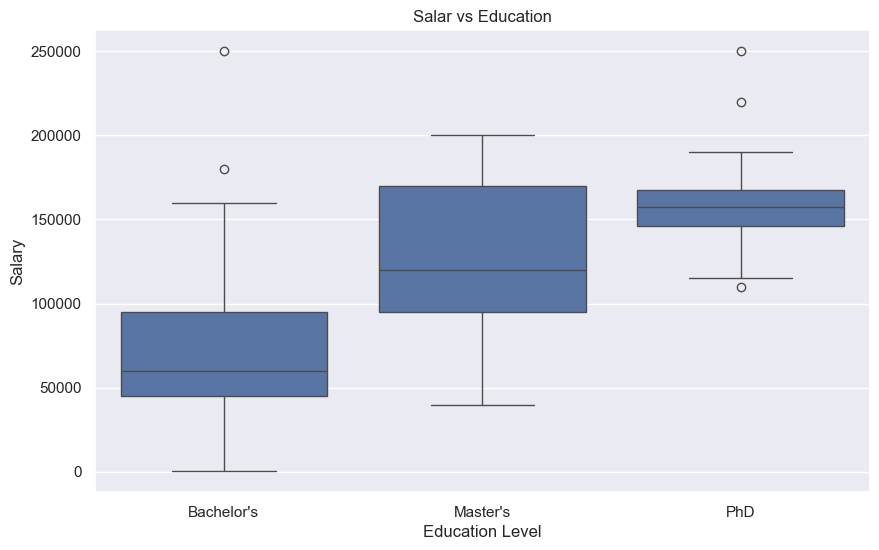

In [144]:
plt.figure(figsize=(10,6))
sb.boxplot(data=df, x="Education Level", y="Salary")
plt.title('Salar vs Education')
plt.show()

### Insights

- Average Salary for each gender

In [145]:
salary_by_gender = df.groupby("Gender")["Salary"].mean().sort_values(ascending=False)
salary_by_gender.apply(lambda x: f"${x:,.2f}")

Gender
Male      $103,472.65
Female     $96,136.36
Name: Salary, dtype: object

- does education level affect salary?

In [146]:
salary_by_education = df.groupby("Education Level")["Salary"].mean().sort_values(ascending=False)
salary_by_education.apply(lambda x: f"${x:,.2f}")

Education Level
PhD           $158,095.24
Master's      $127,912.09
Bachelor's     $73,902.36
Name: Salary, dtype: object

- what about experience level?

In [147]:
# To Convert Years of Experience into 5 Catefoty
def grouping_exp(exp):
    if exp >= 0 and exp <= 5:
        return "0-5 years"
    elif exp > 5 and exp <= 10:
        return "6-10 years"
    elif exp > 10 and exp <= 15:
        return "11-15 years"
    elif exp > 15 and exp <= 20:
        return "16-20 years"
    else:
        return "20+"

salary_by_exp = df.groupby(df["Years of Experience"].apply(grouping_exp))["Salary"].mean().sort_values(ascending=False)
salary_by_exp.apply(lambda x: f"${x:,.2f}")

Years of Experience
20+            $175,400.00
16-20 years    $158,684.21
11-15 years    $115,178.57
6-10 years      $92,215.19
0-5 years       $48,881.78
Name: Salary, dtype: object

- looking at the results, we see that education level and experience do indeed have a certain corelation to salary. 
- as for gender, the difference is too minimal to be conclusive.

### Correlation HeatMap

<Axes: >

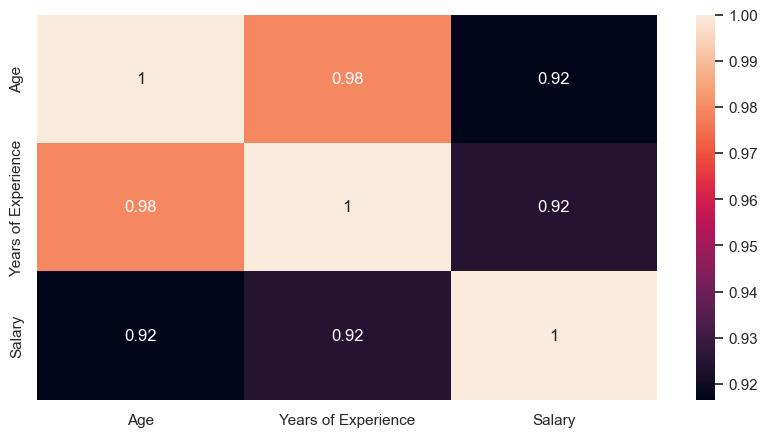

In [148]:
plt.figure(figsize=(10,5))
sb.heatmap(df.corr(numeric_only=True), annot=True)

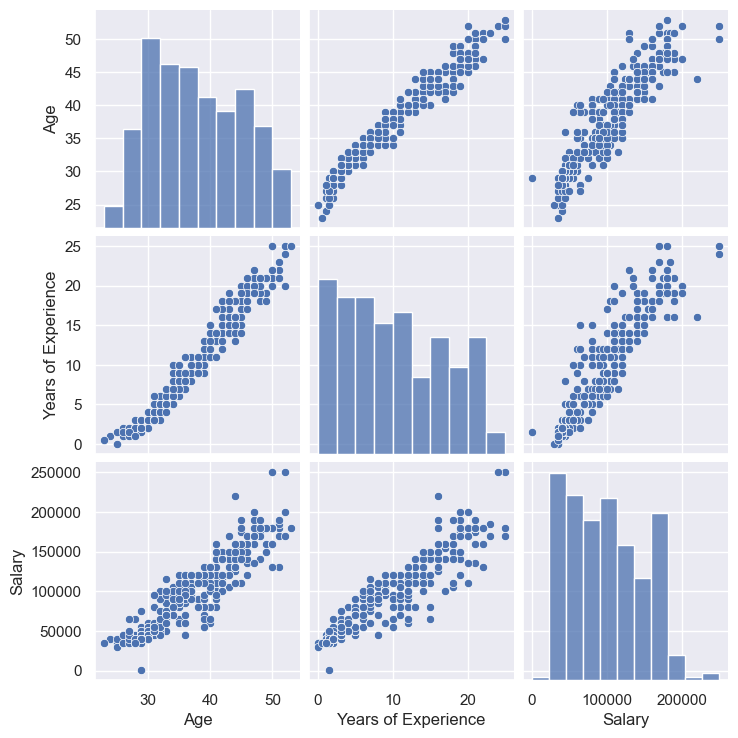

In [149]:
sb.pairplot(df)

#### Analysis
From these graphs & explorations we see that:
- there is a **strong** linear positive correlation between Salary and Age
- there is a **strong** linear positive correlation between Salary and Experience Year

## Random Forest Model

### Encoding Categorical Data

In [150]:
df_encoded = pd.get_dummies(df, columns=["Education Level"], drop_first=True) *1
df_encoded.head()

,Age,Gender,Job Title,Years of Experience,Salary,Education Level_Master's,Education Level_PhD
0,32.0,Male,Software Engineer,5.0,90000.0,0,0
1,28.0,Female,Data Analyst,3.0,65000.0,1,0
2,45.0,Male,Senior Manager,15.0,150000.0,0,1
3,36.0,Female,Sales Associate,7.0,60000.0,0,0
4,52.0,Male,Director,20.0,200000.0,1,0


### Selecting Features

In [151]:
X = df_encoded.drop(columns=["Job Title", "Salary", "Gender"])
y = df_encoded["Salary"]

In [152]:
X.head()

,Age,Years of Experience,Education Level_Master's,Education Level_PhD
0,32.0,5.0,0,0
1,28.0,3.0,1,0
2,45.0,15.0,0,1
3,36.0,7.0,0,0
4,52.0,20.0,1,0


### Splitting Data

In [153]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

### Cross Validation Score

In [154]:
### Cross Validation Score
kf = KFold(n_splits=10, shuffle=True, random_state=30)
rf= RandomForestRegressor(n_estimators=500, random_state=11)
scores = cross_val_score(rf, X, y, cv=kf)
print(f"Cross Validation Score: {np.mean(scores)*100:0.2f}%")

Cross Validation Score: 85.81%


### Fitting the model

In [155]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=11)

In [156]:
score = rf.score(X_train, y_train) * 100
print(f"Model Score: {np.round(score, 2)}%")

Model Score: 94.15%


### Predicting 

In [157]:
predicted_salary = np.round(rf.predict(X_test))
d = {
    "Actual_Salary" : y_test,
    "Predicted_Salary": predicted_salary,
    "error" : predicted_salary - y_test
}
predicted_df = pd.DataFrame(d)
predicted_df.head()

,Actual_Salary,Predicted_Salary,error
224,160000.0,152630.0,-7370.0
279,140000.0,130743.0,-9257.0
130,160000.0,178505.0,18505.0
186,100000.0,93598.0,-6402.0
149,175000.0,170956.0,-4044.0


In [158]:
score = r2_score(y_test, predicted_salary)*100
print(f"Model Score: {np.round(score, 2)}%")

Model Score: 93.58%


In [159]:
rmse = np.sqrt(mean_squared_error(y_test, predicted_salary))
print(f"Error Ratio: {rmse:.3f}")

Error Ratio: 12844.269


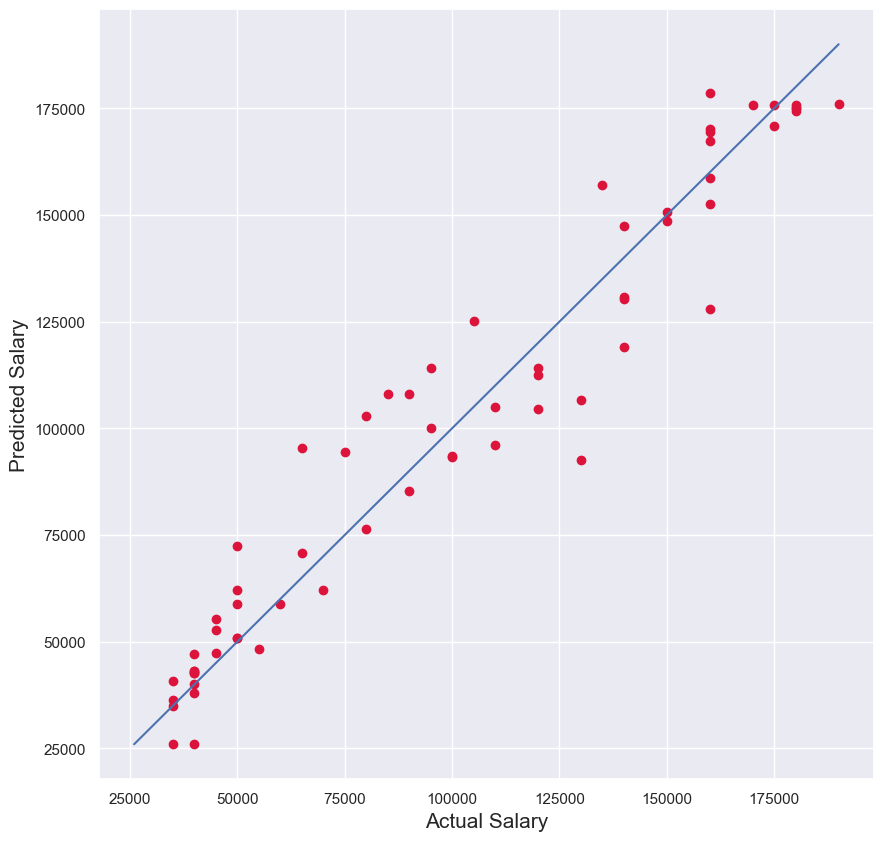

In [160]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predicted_salary, c='crimson')


p1 = max(max(predicted_salary), max(y_test))
p2 = min(min(predicted_salary), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel("Actual Salary", fontsize=15)
plt.ylabel("Predicted Salary", fontsize=15)
plt.show()

### Overall Analysis of the Random Forest Model
- Cross Validation Score: 85.81%
- Model Score: 94.15
- Error ratio: 12844.269
- As seen from the graph above, we are able to predict consistently salary based on the the variables:
    - Age
    - Years of Experience
    - Education Level